# Figure6 peaks overlap

## Plots

* Peaks overlap
* Peaks overlap with ENCODE MACS2 default
* Peaks overlap with ENCODE downloaded files
* Peaks overlap with ENCODE processed the same tool the same way.


## Input

* Peak Calling Summary - aging.tsv
* Peak Calling Summary - encode.tsv
* Downloaded GSM BED files for encode CD14+ at `/mnt/stripe/bio/experiments/figures`
* * GSM1003559_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27acPk.broadPeak
* * GSM1003564_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27me3Pk.broadPeak
* * GSM1003562_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k36me3Pk.broadPeak
* * GSM1003535_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me1Pk.broadPeak
* * GSM1003536_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me3Pk.broadPeak



In [116]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd

df = pd.read_csv('/mnt/stripe/bio/experiments/figures/Peak Calling Summary - aging.tsv', sep='\t')
df = df.loc[df['Status'] != 'Failed'][['donor', 'modification', 'tool', 'peaks', 'procedure', 'file']]
display(df.head(1))

,donor,modification,tool,peaks,procedure,file
0,OD1,H3K27ac,MACS2,21843,default,/mnt/stripe/bio/experiments/aging/peak_calling...


In [117]:
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import downstream.bed_metrics as bm
import downstream.loci_of_interest as loi

from collections import OrderedDict, Counter

toshow = OrderedDict([
    ("H3K27ac", [("MACS2", "default"), ("ZINBRA", "tuned")]),
    ("H3K27me3", [("MACS2", "default"), ("SICER", "default"), ("ZINBRA", "tuned")]),
    ("H3K36me3", [("MACS2", "default"), ("SICER", "default"), ("ZINBRA", "tuned")]),
    ("H3K4me1", [("MACS2", "default"), ("ZINBRA", "tuned")]),
    ("H3K4me3", [("MACS2", "default"), ("ZINBRA", "tuned")])
])


bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        
        paths = [Path(f) for f in files]
        df_path = '/mnt/stripe/bio/experiments/figures/overlap_{}_{}_{}.tsv'.format(m, tool, procedure)
        mt = bm.load_or_build_metrics_table(paths, paths, Path(df_path),
                                            jaccard=False,
                                            threads=30)
        for r in mt.index:
            for c in mt.columns:
                overlap = mt.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, 'all')

        # Look for replicated peaks
        if tool == 'ZINBRA':
            pattern='/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/{}/zinbra_replicated/*any*.bed'.format(m)
            print(pattern)
            replicated_peaks = [Path(f) for f in glob.glob(pattern)]
            print(replicated_peaks)
            if len(replicated_peaks) != 1:
                print(replicated_peaks)
                print("ERROR")

            df_path = '/mnt/stripe/bio/experiments/figures/overlap_replicated_vs_{}_{}_{}.tsv'.format(m, tool, procedure)
            mt = bm.load_or_build_metrics_table(replicated_peaks, 
                                                paths, 
                                                Path(df_path),
                                                jaccard=False,
                                                threads=30)
            for r in mt.index:
                for c in mt.columns:
                    overlap = mt.loc[r][c]
                    bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, 'replicated_vs')

            df_path = '/mnt/stripe/bio/experiments/figures/overlap_vs_replicated_{}_{}_{}.tsv'.format(m, tool, procedure)
            mt = bm.load_or_build_metrics_table(paths, 
                                                replicated_peaks, 
                                                Path(df_path),
                                                jaccard=False,
                                                threads=30)
            for r in mt.index:
                for c in mt.columns:
                    overlap = mt.loc[r][c]
                    bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, 'vs_replicated')

[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27ac_ZINBRA_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27ac/zinbra_replicated/*any*.bed
[PosixPath('/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27ac/zinbra_replicated/any_all_H3K27ac_1.0E-140_5_peaks.bed')]
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_replicated_vs_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_vs_replicated_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27me3_ZINBRA_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27me3/zinbra_replicated/*

In [125]:
def plot_overlaps(dft, xlabels):
    dft['x'] = dft['modification'] + " " + dft['tool'] + " " + dft['procedure']
    
    fig = plt.figure(figsize=(int(len(set(dft['x'])) * 0.75), 5))
    sns.set_style("whitegrid")

    # Bar plots
    ax = sns.barplot(data=dft, 
             x="x", y="overlap",
             ci="sd", capsize=.2, errwidth=2,
             color="lightgray",
             edgecolor="black")

    ax = sns.swarmplot(data=dft, 
                       x="x", y="overlap",
                       size=1, alpha=1.0,
                       hue='direction',
                       palette={'all': 'black', 'replicated_vs': 'red', 'vs_replicated': 'yellow'})


    plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)
    plt.xlabel('')
    plt.ylabel('Overlap')

    fig.text(.15, -.05, 'H3K27ac')
    fig.text(.31, -.05, 'H3K27me3')
    fig.text(.50, -.05, 'H3K36me3')
    fig.text(.67, -.05, 'H3K4me1')
    fig.text(.80, -.05, 'H3K4me3')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    plt.close()

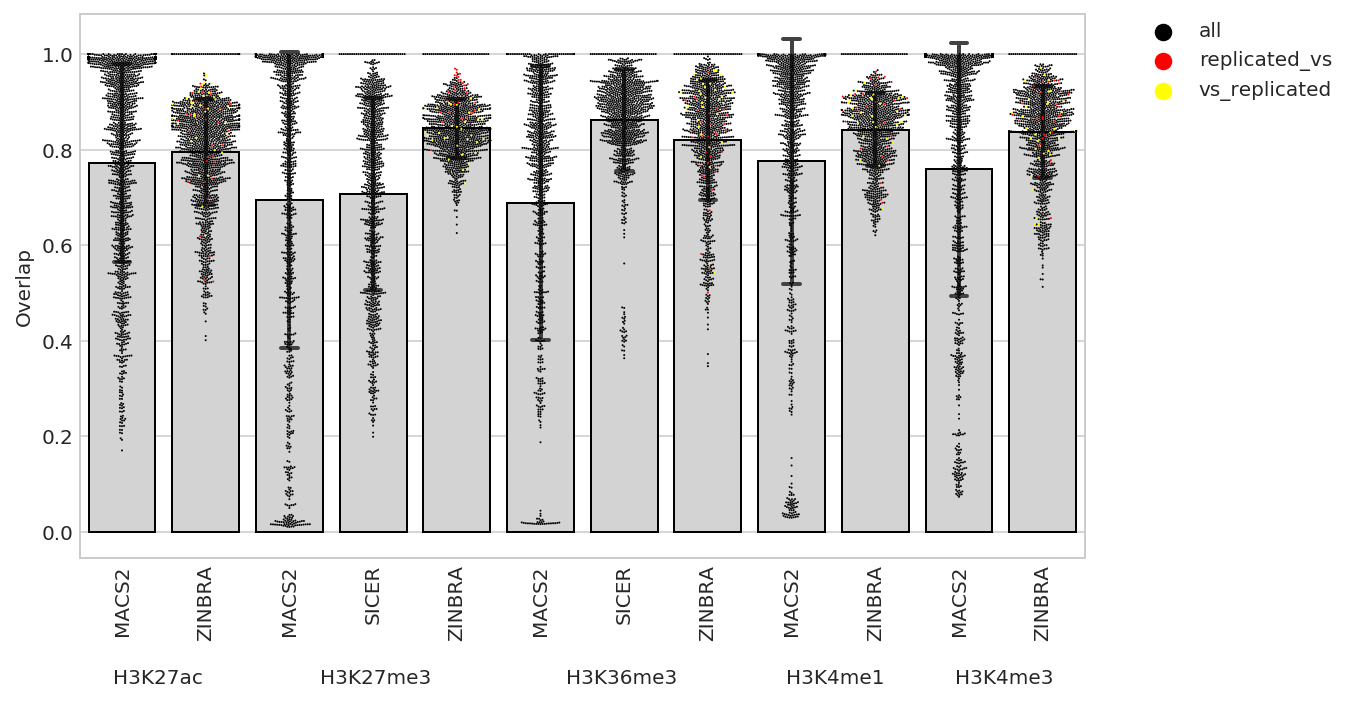

In [126]:
plot_overlaps(bigdf, xlabels)

# Overlap with ENCODE MACS2 default

In [127]:
dfe = pd.read_csv('/mnt/stripe/bio/experiments/figures/Peak Calling Summary - encode.tsv', sep='\t')
dfe = dfe[['donor', 'modification', 'tool', 'peaks', 'procedure', 'file']]
dfe = dfe.loc[np.logical_and(dfe['tool'] == 'MACS2', dfe['procedure'] == 'default')]
display(dfe)

,donor,modification,tool,peaks,procedure,file
0,GSM1003559,H3K27ac,MACS2,48977,default,/mnt/stripe/bio/experiments/configs/benchmark_...
4,GSM1102782,H3K27ac,MACS2,25731,default,/mnt/stripe/bio/experiments/configs/benchmark_...
8,GSM1003564,H3K27me3,MACS2,26417,default,/mnt/stripe/bio/experiments/configs/benchmark_...
14,GSM1102785,H3K27me3,MACS2,14948,default,/mnt/stripe/bio/experiments/configs/benchmark_...
20,GSM945301,H3K27me3,MACS2,8547,default,/mnt/stripe/bio/experiments/configs/benchmark_...
26,GSM1003562,H3K36me3,MACS2,36075,default,/mnt/stripe/bio/experiments/configs/benchmark_...
32,GSM1102788,H3K36me3,MACS2,33969,default,/mnt/stripe/bio/experiments/configs/benchmark_...
38,GSM1003535,H3K4me1,MACS2,63724,default,/mnt/stripe/bio/experiments/configs/benchmark_...
42,GSM1102793,H3K4me1,MACS2,64752,default,/mnt/stripe/bio/experiments/configs/benchmark_...
46,GSM1003536,H3K4me3,MACS2,39589,default,/mnt/stripe/bio/experiments/configs/benchmark_...


In [128]:
import os
from scripts.util import run

method = 'union'
encode_macs2_peaks = {}
for modification in set(dfe['modification']):
    result_file = '/mnt/stripe/bio/experiments/figures/{}_encode_{}.bed'.format(modification, method)
    if not os.path.exists(result_file):
        files = list(dfe.loc[dfe['modification'] == modification]['file'])
        cmd = ['bash', '/mnt/stripe/washu/bed/{}.sh'.format(method)] + files
        with open(result_file, mode='w') as out:
            run([cmd], stdout=out)
    encode_macs2_peaks[modification] = result_file
display(encode_macs2_peaks)

{'H3K27ac': '/mnt/stripe/bio/experiments/figures/H3K27ac_encode_union.bed',
 'H3K27me3': '/mnt/stripe/bio/experiments/figures/H3K27me3_encode_union.bed',
 'H3K36me3': '/mnt/stripe/bio/experiments/figures/H3K36me3_encode_union.bed',
 'H3K4me1': '/mnt/stripe/bio/experiments/figures/H3K4me1_encode_union.bed',
 'H3K4me3': '/mnt/stripe/bio/experiments/figures/H3K4me3_encode_union.bed'}

In [130]:
# Plot 2way overlaps on the single plot vs ENCODE with separation to red/blue
def plot_overlaps_2(dft, xlabels):
    dft["age"] = "Young"
    dft.loc[["OD" in v for v in dft['id']], "age"] = "Old"


    dft['x'] = dft['modification'] + " " + dft['tool'] + " " + dft['procedure']
    
    fig = plt.figure(figsize=(int(len(set(dft['x'])) * 0.75), 5))
    sns.set_style("whitegrid")

    # Bar plots
    ax = sns.barplot(data=dft, 
                     x="x", y="overlap",
                     ci="sd", capsize=.2, errwidth=2,
                     color="lightgray",
                     hue = "direction",
                     edgecolor="black")

    # Add jitter with the swarmplot function.
    ax = sns.swarmplot(data=dft.loc[dft['age']=='Young'], 
                       x="x", y="overlap",
                       size=3,
                       hue="direction",
                       palette=["red", "red"],
                       dodge=True)

    # Add jitter with the swarmplot function.
    ax = sns.swarmplot(data=dft.loc[dft['age']=='Old'], 
                       x="x", y="overlap",
                       size=3,
                       hue="direction",
                       palette=["blue", "blue"],
                       dodge=True)

    plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)
    plt.xlabel('')
    plt.ylabel('Overlap')

    fig.text(.15, -.05, 'H3K27ac')
    fig.text(.31, -.05, 'H3K27me3')
    fig.text(.50, -.05, 'H3K36me3')
    fig.text(.67, -.05, 'H3K4me1')
    fig.text(.80, -.05, 'H3K4me3')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    plt.close()

H3K27ac MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_union_H3K27ac_MACS2_default.tsv
H3K27ac ZINBRA tuned
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_union_H3K27ac_ZINBRA_tuned.tsv
H3K27me3 MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_union_H3K27me3_MACS2_default.tsv
H3K27me3 SICER default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/

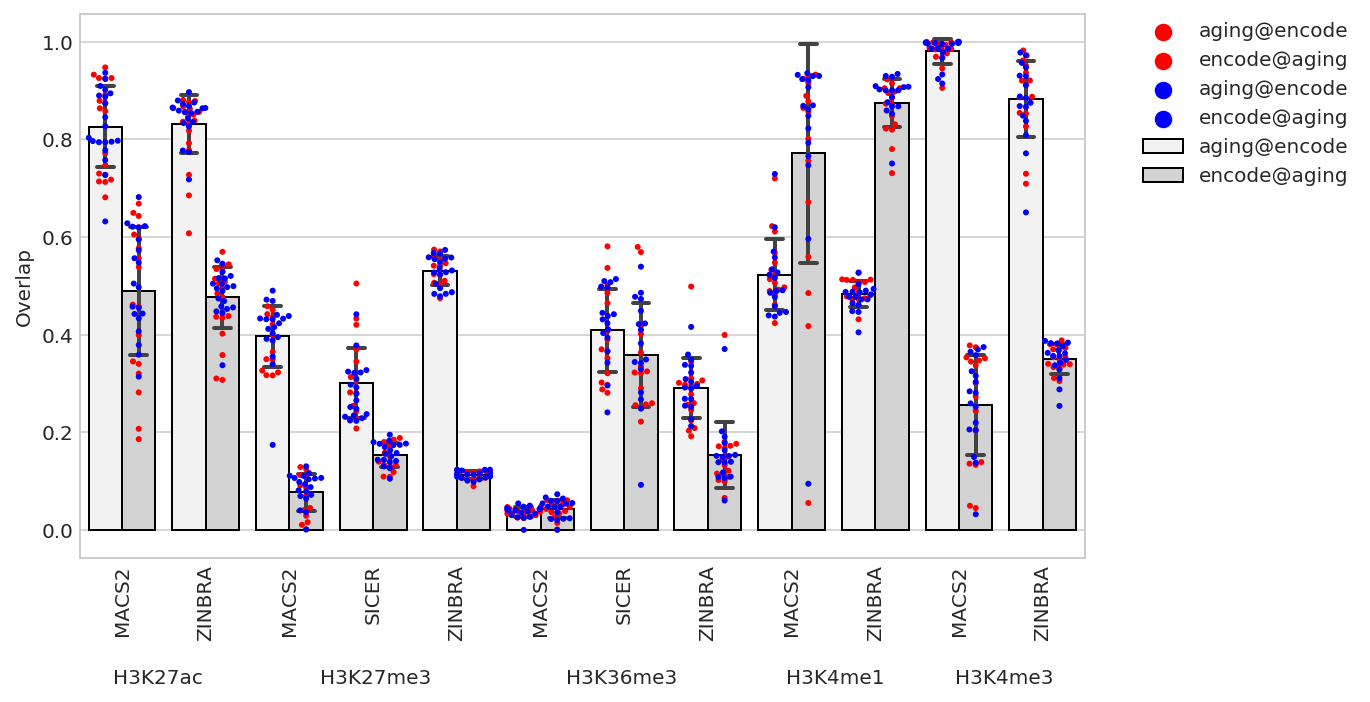

In [131]:
bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Aging @ ENCODE
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        aging_at_encode = bm.load_or_build_metrics_table([Path(f) for f in files],
                                             [Path(encode_macs2_peaks[modification])],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in aging_at_encode.index:
            for c in aging_at_encode.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, aging_at_encode.loc[r][c], "aging@encode")
        
        # ENCODE @ Aging
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        encode_at_aging = bm.load_or_build_metrics_table([Path(encode_macs2_peaks[modification])],
                                            [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in encode_at_aging.index:
            for c in encode_at_aging.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, encode_at_aging.loc[r][c], "encode@aging")


plot_overlaps_2(bigdf, xlabels)

# VS ENCODE downloaded BED files
Actuallly this is not the 100% truth, since we get some females here as well as tool bias.

H3K27ac MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_union_H3K27ac_MACS2_default.tsv
H3K27ac ZINBRA tuned
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_union_H3K27ac_ZINBRA_tuned.tsv
H3K27me3 MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_union_H3K27me3_MACS2_default.tsv
H3K27me3 SICER default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/fi

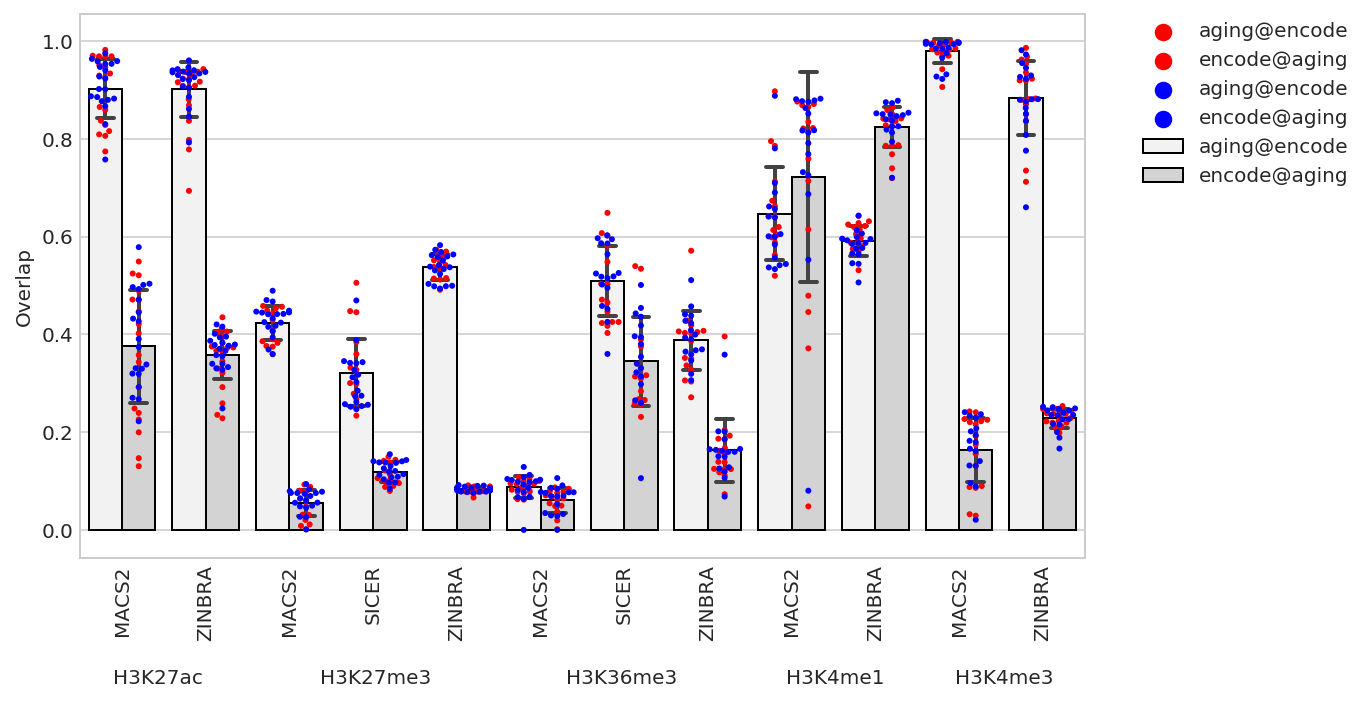

In [132]:
encode_peaks_bed={
    'H3K27ac': '/mnt/stripe/bio/experiments/figures/GSM1003559_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27acPk.broadPeak',
    'H3K27me3': '/mnt/stripe/bio/experiments/figures/GSM1003564_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27me3Pk.broadPeak',
    'H3K36me3': '/mnt/stripe/bio/experiments/figures/GSM1003562_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k36me3Pk.broadPeak',
    'H3K4me1': '/mnt/stripe/bio/experiments/figures/GSM1003535_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me1Pk.broadPeak',
    'H3K4me3': '/mnt/stripe/bio/experiments/figures/GSM1003536_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me3Pk.broadPeak'
}

bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Aging @ ENCODE
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        aging_at_encode = bm.load_or_build_metrics_table([Path(f) for f in files],
                                             [Path(encode_peaks_bed[modification])],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in aging_at_encode.index:
            for c in aging_at_encode.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, aging_at_encode.loc[r][c], "aging@encode")
        
        # ENCODE @ Aging
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        encode_at_aging = bm.load_or_build_metrics_table([Path(encode_peaks_bed[modification])],
                                            [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in encode_at_aging.index:
            for c in encode_at_aging.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, encode_at_aging.loc[r][c], "encode@aging")


plot_overlaps_2(bigdf, xlabels)

# Overlap with ENCODE processed the same manner

In [133]:
import glob

# ENCODE male CD14 samples
encode_gsms = {
    'H3K27ac': 'GSM1102782',
    'H3K27me3': 'GSM1102785',
    'H3K36me3': 'GSM1102788',
    'H3K4me1': 'GSM1102793',
    'H3K4me3': 'GSM1102797',
}

bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Add encode overlap index
        if procedure == 'tuned':
            pattern = '/mnt/stripe/bio/experiments/configs/benchmark_encode/benchmark/{}/{}'
        else:
            pattern = '/mnt/stripe/bio/experiments/configs/benchmark_encode/default/{}/{}'
        if tool == 'ZINBRA':
            f = 'zinbra'
        elif tool == 'SICER':
            f = 'sicer'
        elif tool == 'MACS2':
            f = 'macs_broad'
        else: 
            print("Unknown tool")
        folder = pattern.format(m, f)
        encode_paths = []
        encode_paths.extend(glob.glob(folder + '/*' + encode_gsms[m] + '*.broadPeak'))
        encode_paths.extend(glob.glob(folder + '/*' + encode_gsms[m] + '*.narrowPeak')) 
        encode_paths.extend(glob.glob(folder + '/*' + encode_gsms[m] + '*.bed'))
#         print("ENCODE paths", encode_paths)
#         print("FILES", len(files))
        if len(encode_paths) == 0:
            print("ERROR")
        
        # Compute Aging @ ENCODE overlap
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_{}_{}_{}_{}.tsv'\
            .format(method, m, tool, procedure)
        mte = bm.load_or_build_metrics_table([Path(f) for f in files], 
                                             [Path(f) for f in encode_paths],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in mte.index:
            for c in mte.columns:
                overlap = mte.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, "aging@encode")

        # Compute ENCODE @ Aging overlap
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_{}_{}_{}_{}.tsv'\
            .format(method, m, tool, procedure)
        mte = bm.load_or_build_metrics_table([Path(f) for f in encode_paths],
                                             [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in mte.index:
            for c in mte.columns:
                overlap = mte.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, "encode@aging")

H3K27ac MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_union_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_union_H3K27ac_MACS2_default.tsv
H3K27ac ZINBRA tuned
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_union_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_union_H3K27ac_ZINBRA_tuned.tsv
H3K27me3 MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_union_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_union_H3K27me3_MACS2_default.tsv
H3K27me3 SICER default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_union_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_agin

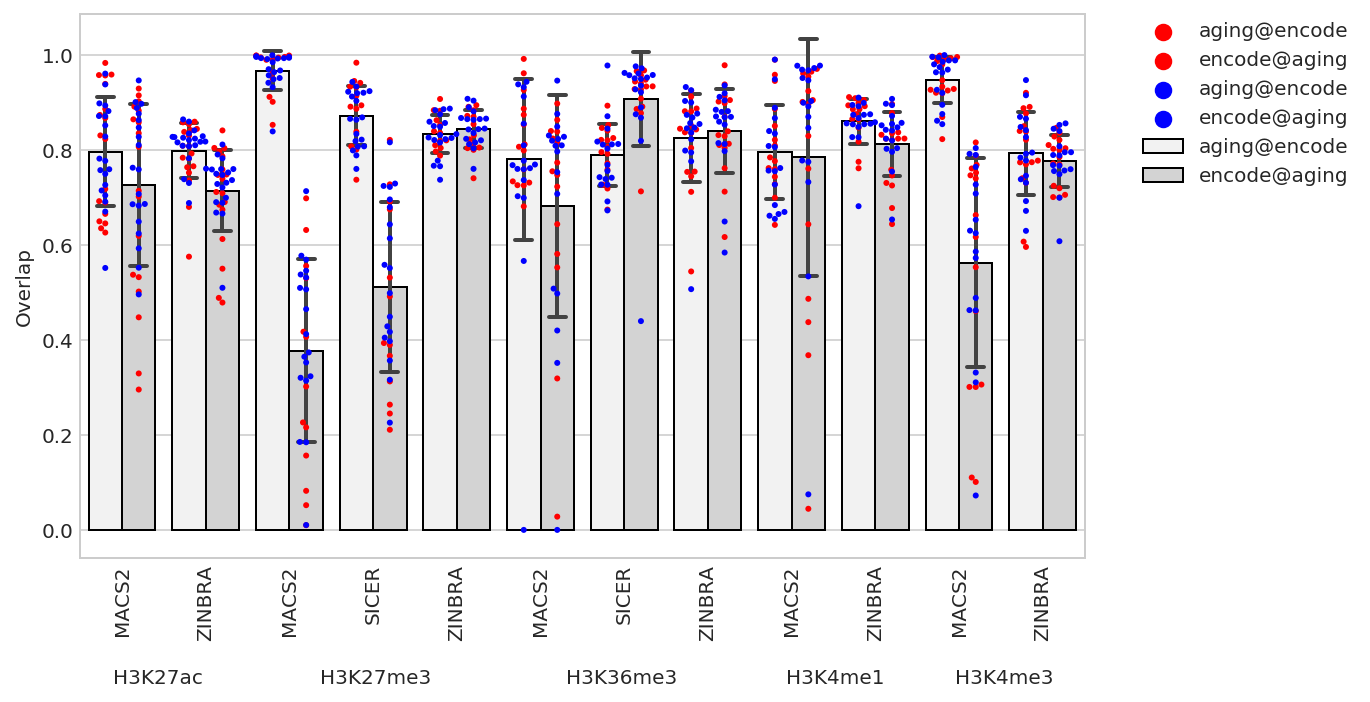

In [134]:
plot_overlaps_2(bigdf, xlabels)